Nombre de NaN dans y_train: 642
Nombre de NaN dans chaque colonne de X_train:
R2     0
R7     0
R8     0
R17    0
R22    0
R32    0
dtype: int64
Dimensions de X_train: (303, 6)
Taille de y_train: (303,)


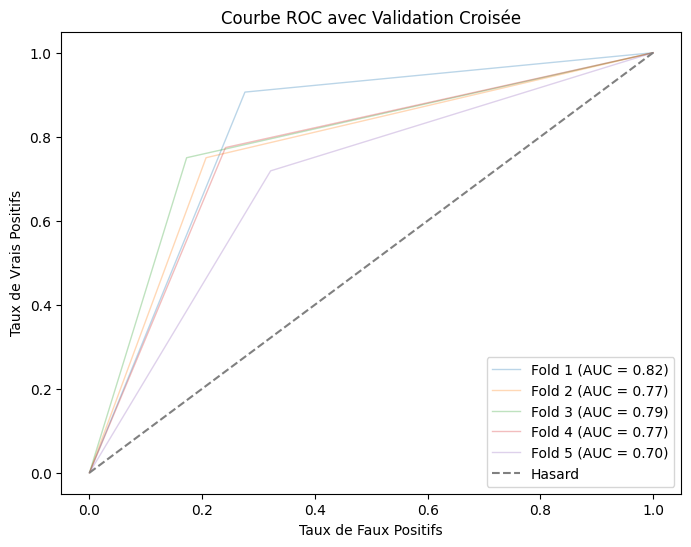

AUC moyenne : 0.77 ± 0.04
Les prédictions ont été sauvegardées dans 'test_predictions.csv'.


In [20]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# 1. Charger les données d'entraînement
train_df = pd.read_csv('/content/farms_train.csv', sep=';', decimal=',')


# 2. Préparer les données d'entraînement
# a. Séparer les variables indépendantes et la variable cible
X_train = train_df.drop('DIFF', axis=1)
y_train = train_df['DIFF']

# b. Vérifier et supprimer les NaN dans y_train
print("Nombre de NaN dans y_train:", y_train.isnull().sum())
train_data = X_train.copy()
train_data['DIFF'] = y_train
train_data = train_data.dropna(subset=['DIFF'])
X_train = train_data.drop('DIFF', axis=1)
y_train = train_data['DIFF'].astype(int)

# c. Vérifier les NaN dans X_train
print("Nombre de NaN dans chaque colonne de X_train:")
print(X_train.isnull().sum())

# d. Imputer les NaN dans X_train avec la moyenne des colonnes
X_train = X_train.fillna(X_train.mean())

# e. Vérifier que X_train et y_train sont alignés
print("Dimensions de X_train:", X_train.shape)
print("Taille de y_train:", y_train.shape)

# f. Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. Évaluer le modèle avec validation croisée
model = DecisionTreeClassifier(random_state=42)

# a. Utiliser Stratified K-Fold pour conserver la proportion des classes
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    X_cv_train, X_cv_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_cv_train, y_cv_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(X_cv_train, y_cv_train)
    y_proba = model.predict_proba(X_cv_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_cv_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Fold %d (AUC = %0.2f)' % (i+1, roc_auc))

# b. Tracer la courbe ROC moyenne
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Hasard')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC avec Validation Croisée')
plt.legend(loc='lower right')
plt.show()

# c. Afficher l'AUC moyenne
print('AUC moyenne : %0.2f ± %0.2f' % (np.mean(aucs), np.std(aucs)))

# 4. Entraîner le modèle sur l'ensemble du jeu de données d'entraînement
model.fit(X_train_scaled, y_train)

# 5. Charger et préparer le jeu de données de test
test_df = pd.read_csv('/content/farms_test.csv', sep=';', decimal=',')



X_test = test_df.copy()

# a. Vérifier les colonnes manquantes ou supplémentaires
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = X_train[col].mean()

extra_cols = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns=extra_cols)

# b. Réordonner les colonnes pour correspondre à X_train
X_test = X_test[X_train.columns]

# c. Imputer les NaN dans X_test avec la moyenne des colonnes
X_test = X_test.fillna(X_test.mean())

# d. Standardiser X_test avec le même scaler
X_test_scaled = scaler.transform(X_test)

# 6. Faire des prédictions sur le jeu de données de test
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# 7. Sauvegarder les prédictions dans un fichier CSV
output = X_test.copy()
output['DIFF_Predicted'] = y_pred
output['Probability'] = y_pred_proba

output.to_csv('test_predictions.csv', index=False)
print("Les prédictions ont été sauvegardées dans 'test_predictions.csv'.")
